# **Email Spam Detection**

# Importing Libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import nltk
import seaborn as sns

# Importing Dataset

In [3]:
df = pd.read_csv("/content/spam.csv",encoding='latin-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# EDA and Pre-Processing

In [5]:
df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


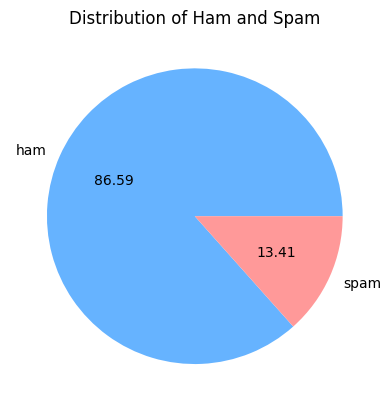

In [21]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'],autopct='%0.2f', colors=['#66b3ff','#ff9999'])
plt.title('Distribution of Ham and Spam')
plt.show()

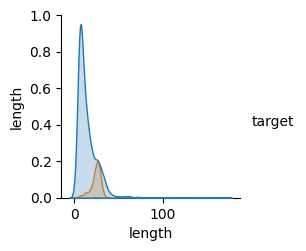

In [26]:
sns.pairplot(df, hue='target')

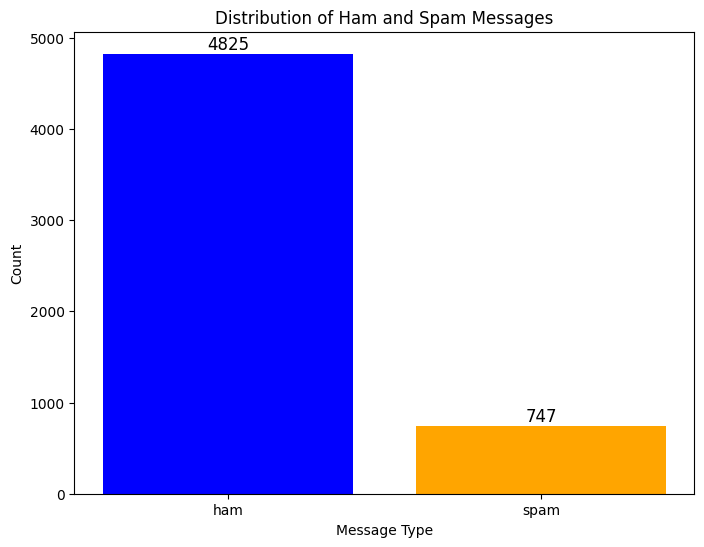

In [30]:
label_counts = df['target'].value_counts()
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center', fontsize=12)
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.title('Distribution of Ham and Spam Messages')
plt.show()

# Separating Data into ham and spam

In [7]:
df['length'] = df['message'].apply(lambda x: len(x.split(' ')))
ham_length = df[df['target'] == 'ham']['length']
spam_length = df[df['target'] == 'spam']['length']
print(f'Max length ham message: {max(ham_length)}')
print(f'Max length spam message: {max(spam_length)}')

Max length of ham message: 171
Max length of spam message: 35


# Plotting Histogram

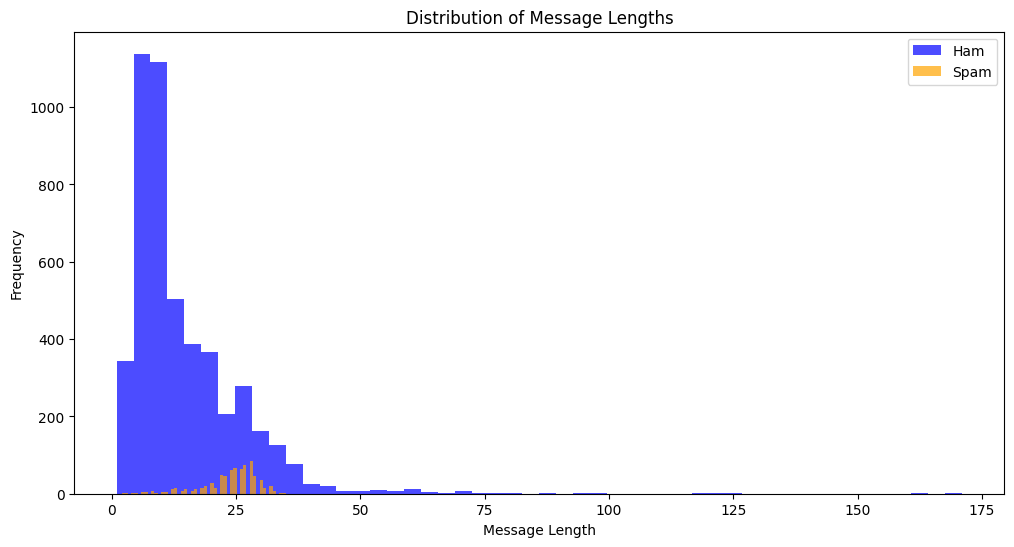

In [8]:
plt.figure(figsize=(12, 6))
plt.hist(ham_length, bins=50, alpha=0.7, label='Ham', color='blue')
plt.hist(spam_length, bins=50, alpha=0.7, label='Spam', color='orange')
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Removing urls, mentions and punctuations

In [9]:
def remove_punc(text):
    url_pattern = r'https?://\S+|www\.\S+'
    mention_pattern = r'@\w+'
    text = re.sub(url_pattern, '', text)
    text = re.sub(mention_pattern, '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text.strip()
df['wo_punc'] = df['message'].apply(lambda text: remove_punc(text))

# Removing Stopwords

In [12]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
df["wo_stop"] = df["wo_punc"].apply(lambda text: remove_stopwords(text))

# Applying Stemming

In [13]:
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])
df["stemmed_text"] = df["wo_stop"].apply(lambda text: stem_words(text))
df.head()

,target,message,length,wo_punc,wo_stop,stemmed_text
0,ham,"Go until jurong point, crazy.. Available only ...",20,Go until jurong point crazy Available only in ...,Go jurong point crazy Available bugis n great ...,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,Ok lar Joking wif u oni,Ok lar Joking wif u oni,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry 2 wkly comp win FA Cup final tkts 2...,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,11,U dun say so early hor U c already then say,U dun say early hor U c already say,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,Nah I dont think he goes to usf he lives aroun...,Nah I dont think goes usf lives around though,nah i dont think goe usf live around though


# Spliting into train and test sets

In [14]:
X = df['stemmed_text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4179,) (4179,)
(1393,) (1393,)


In [15]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
vocab_size = len(vectorizer.vocabulary_)
print(f'Vocabulary Size: {vocab_size}')

Vocabulary Size: 6844


# Trainning the model

In [16]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

# Evaluating the model

In [18]:
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='spam')
recall = recall_score(y_test, y_pred, pos_label='spam')
f1 = f1_score(y_test, y_pred, pos_label='spam')

In [19]:
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.95
Precision: 0.98
Recall: 0.64
F1 Score: 0.77


# Printing classification report & Confusion Matrix

In [20]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Classification Report:
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97      1202
        spam       0.98      0.64      0.77       191

    accuracy                           0.95      1393
   macro avg       0.96      0.82      0.87      1393
weighted avg       0.95      0.95      0.94      1393


Confusion Matrix:
[[1199    3]
 [  69  122]]
